## Introduction
In this notebook, we build a model that predicts property crime in New York based on the 3 features of population, murders, and robberies.  We have modeled another feature that simply squares the population of each particular city.  The number of murders and robberies were converted to categorical values of 0 (if not a single instance occurred) and 1 (if at least one instance occurred).

## Importing and cleaning the data

In [181]:
# importing pnadas modules
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [182]:
# importing raw data from excel into a pandas dataframe
df_raw = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

# display raw file
df_raw.head(n=10)

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0
5,Addison Town and Village,2577,3,0,NaN,0,0,3,24,3,20,1,0
6,Akron Village,2846,3,0,NaN,0,0,3,16,1,15,0,0
7,Albany,97956,791,8,NaN,30,227,526,4090,705,3243,142,NaN
8,Albion Village,6388,23,0,NaN,3,4,16,223,53,165,5,NaN
9,Alfred Village,4089,5,0,NaN,0,3,2,46,10,36,0,NaN


As you can see here, we have some extra rows at the top and we need to label the columns in accordance with row 3 which gives the column headings.

In [183]:
# show last 5 lines of raw file; last 3 lines need to be removed
df_raw.tail()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
350,Yonkers,199134,1036,6,NaN,25,390,615,2368,470,1662,236,10
351,Yorktown Town,36643,15,0,NaN,0,2,13,334,45,287,2,NaN
352,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
353,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
354,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The last few rows here need to be deleted since they contain no data.  We also need to check for missing or NaN values in the data.

In [184]:
# setting the proper heading from the 4th row of raw data
headers = df_raw.iloc[3]

# exclude rows 1 through 4 (or rows 0, 1, 2, 3)
df_ny = pd.DataFrame(df_raw.values[4:], columns=headers)

# renaming columns
df_ny.columns = ['city', 'pop', 'vc', 'murder', 'rape1', 'rape2', 'robbery', 'aa', 'pc', 'burglary', 'lt', 'mvt', 'arson3']
df_ny_all = df_ny

# dropping unnecessary columns
df_ny = df_ny.drop(['vc', 'rape1', 'rape2', 'aa', 'burglary', 'lt', 'mvt', 'arson3'], axis=1)

# drop some of the columns for later use
df_ny_some = df_ny_all.drop(['vc', 'rape1', 'rape2', 'lt', 'mvt', 'arson3'], axis=1)

# removing last 3 rows of instructional data
df_ny = df_ny.drop([348, 349, 350], axis=0)

In [185]:
df_ny.head()

,city,pop,murder,robbery,pc
0,Adams Village,1861,0,0,12
1,Addison Town and Village,2577,0,0,24
2,Akron Village,2846,0,0,16
3,Albany,97956,8,227,4090
4,Albion Village,6388,0,4,223


This is much better.  Now, you can see that we have dropped some unnecessary columns as we are only concerned with the city, population, murder and robbery.  These columns have been renamed from the raw data for ease of use and convenience.  We also dropped the last 3 explanatory rows from the dataframe.  The next step is to convert the numbers to floats and add another feature called 'pop2' which is the population squared for each city.

In [186]:
#converting string values to float and creating 'pop2' column which is pop squared

df_ny["pop"] = [np.float(x) for x in df_ny["pop"]]
df_ny["pop2"] = [np.float(x*x) for x in df_ny["pop"]]
df_ny["murder"] = [np.float(x) for x in df_ny["murder"]]
df_ny["robbery"] = [np.float(x) for x in df_ny["robbery"]]
df_ny["pc"] = [np.float(x) for x in df_ny["pc"]]

In [187]:
df_ny.dtypes

city        object
pop        float64
murder     float64
robbery    float64
pc         float64
pop2       float64
dtype: object

Next, we'll convert the murder and robbery features to categorical values.

In [188]:
# If murders or robberies in greater than 0, convert to 1 else leave at 0
df_ny['murder'] = df_ny['murder'].apply(lambda x : 1 if x>0 else 0)
df_ny['robbery'] = df_ny['robbery'].apply(lambda x : 1 if x>0 else 0)
df_ny.head()

,city,pop,murder,robbery,pc,pop2
0,Adams Village,1861.000,0,0,12.000,3463321.000
1,Addison Town and Village,2577.000,0,0,24.000,6640929.000
2,Akron Village,2846.000,0,0,16.000,8099716.000
3,Albany,97956.000,1,1,4090.000,9595377936.000
4,Albion Village,6388.000,0,1,223.000,40806544.000


We've now got all of the data needed at this point and in the correct format to begin constructing our model.

## Data exploration

First, look for any missing or NaN values.

In [189]:
df_ny.isnull().sum()

city       0
pop        0
murder     0
robbery    0
pc         0
pop2       0
dtype: int64

Looks good so far, no missing values.  

Next, let's just look at the property crime versus population with a scatterplot.

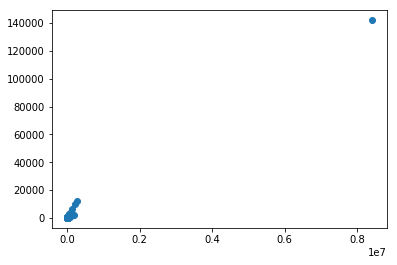

In [190]:
plt.scatter(df_ny['pop'], df_ny['pc'])

It looks like we have a massive outlier here that could easily cause problems building a reliable model.  Let's find out what this outlier is and remove it and look again at the scatterplot.

In [191]:
print(min(df_ny['pop']))
print(max(df_ny['pc']))
print(df_ny.loc[df_ny['city'] == 'New York'])
print('\n')
print(df_ny.loc[df_ny['pop'] == 526.0])

526.0
141971.0
         city         pop  murder  robbery         pc               pop2
216  New York 8396126.000       1        1 141971.000 70494931807876.000


                  city     pop  murder  robbery    pc       pop2
118  Glen Park Village 526.000       0        0 5.000 276676.000


So the city in question is New York City which has a population of 141,971.

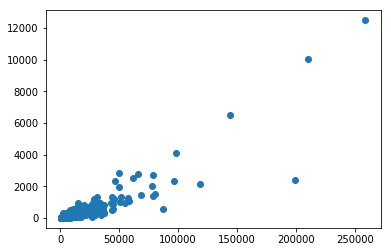

In [192]:
# drop nyc data
df_no_nyc = df_ny.drop([216])

# produce new scatterplot
plt.scatter(df_no_nyc['pop'], df_no_nyc['pc'])

This looks much better; more conducive to building an accurate model.  Next, let's look to see if there are any strong correlations between all of the features to see if some are redundant and unnecessary.

In [193]:
df_ny_all.tail()

,city,pop,vc,murder,rape1,rape2,robbery,aa,pc,burglary,lt,mvt,arson3
346,Yonkers,199134,1036,6,NaN,25,390,615,2368,470,1662,236,10
347,Yorktown Town,36643,15,0,NaN,0,2,13,334,45,287,2,NaN
348,1 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
349,2 The figures shown in this column for the off...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350,3 The FBI does not publish arson data unless i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [194]:
df_ny_all = df_ny_all.drop(['rape1', 'arson3'], axis=1)

# removing last 3 rows of instructional data
df_ny_all = df_ny_all.drop([348, 349, 350], axis=0)

df_ny_all.isnull().sum()

df_ny_all.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt
0,Adams Village,1861,0,0,0,0,0,12,2,10,0
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1
2,Akron Village,2846,3,0,0,0,3,16,1,15,0
3,Albany,97956,791,8,30,227,526,4090,705,3243,142
4,Albion Village,6388,23,0,3,4,16,223,53,165,5


In [195]:
#converting string values to float and creating 'pop2' column which is pop squared

df_ny_all["pop"] = [np.float(x) for x in df_ny_all["pop"]]
df_ny_all["pop2"] = [np.float(x*x) for x in df_ny_all["pop"]]
df_ny_all["vc"] = [np.float(x) for x in df_ny_all["vc"]]
df_ny_all["murder"] = [np.float(x) for x in df_ny_all["murder"]]
df_ny_all["rape2"] = [np.float(x) for x in df_ny_all["rape2"]]
df_ny_all["robbery"] = [np.float(x) for x in df_ny_all["robbery"]]
df_ny_all["aa"] = [np.float(x) for x in df_ny_all["aa"]]
df_ny_all["pc"] = [np.float(x) for x in df_ny_all["pc"]]
df_ny_all["burglary"] = [np.float(x) for x in df_ny_all["burglary"]]
df_ny_all["lt"] = [np.float(x) for x in df_ny_all["lt"]]
df_ny_all["mvt"] = [np.float(x) for x in df_ny_all["mvt"]]


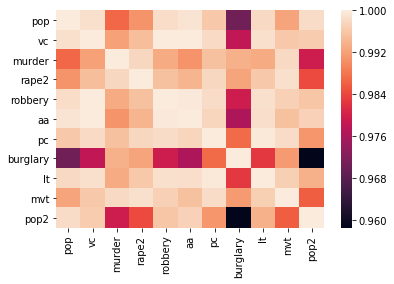

In [196]:
# Compute pairwise correlation of columns, excluding NA/null values (with .corr); then create the heatmap.
sns.heatmap(df_ny_all.corr())


This is the heatmap with NYC data.  Everything is extremely highly correlated (probably overfit).  We can also see that pop and pop2 are practically perfectly correlated, so we can drop pop2.

In [197]:
# drop nyc data
df_ny_all_no_nyc = df_ny_all.drop([216])

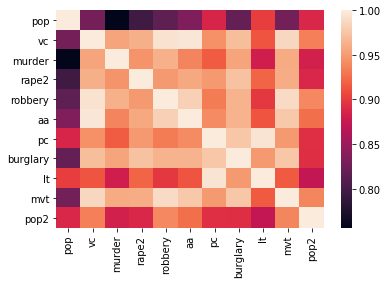

In [198]:
# Compute pairwise correlation of columns, excluding NA/null values (with .corr); then create the heatmap.
sns.heatmap(df_ny_all_no_nyc.corr())


This heatmap leave out NYC data.  We can see the strong positive correlation between population (pop) and property crime (pc) which looks like about 0.90.  Also, we see that the model does not look to be overfit as correlations go as low as 0.75.  It looks like aggravated assault (aa) is the least correlated feature here, so maybe this feature is the best one to use next time to build a better model.

In [199]:
df_ny_all.head()

,city,pop,vc,murder,rape2,robbery,aa,pc,burglary,lt,mvt,pop2
0,Adams Village,1861.000,0.000,0.000,0.000,0.000,0.000,12.000,2.000,10.000,0.000,3463321.000
1,Addison Town and Village,2577.000,3.000,0.000,0.000,0.000,3.000,24.000,3.000,20.000,1.000,6640929.000
2,Akron Village,2846.000,3.000,0.000,0.000,0.000,3.000,16.000,1.000,15.000,0.000,8099716.000
3,Albany,97956.000,791.000,8.000,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,9595377936.000
4,Albion Village,6388.000,23.000,0.000,3.000,4.000,16.000,223.000,53.000,165.000,5.000,40806544.000


In [200]:
# drop some of the columns for later use
#df_ny_some = df_ny_all.drop(['vc', 'rape1', 'lt', 'mvt', 'arson3'], axis=1)
df_ny_some.head()

,city,pop,murder,robbery,aa,pc,burglary
0,Adams Village,1861,0,0,0,12,2
1,Addison Town and Village,2577,0,0,3,24,3
2,Akron Village,2846,0,0,3,16,1
3,Albany,97956,8,227,526,4090,705
4,Albion Village,6388,0,4,16,223,53


In [201]:
#converting string values to float and creating 'pop2' column which is pop squared

df_ny_some["pop"] = [np.float(x) for x in df_ny_some["pop"]]
df_ny_some["pop2"] = [np.float(x*x) for x in df_ny_some["pop"]]
df_ny_some["murder"] = [np.float(x) for x in df_ny_some["murder"]]
df_ny_some["robbery"] = [np.float(x) for x in df_ny_some["robbery"]]
df_ny_some["aa"] = [np.float(x) for x in df_ny_some["aa"]]
df_ny_some["pc"] = [np.float(x) for x in df_ny_some["pc"]]
df_ny_some["burglary"] = [np.float(x) for x in df_ny_some["burglary"]]


In [202]:
df_ny_some.head()

,city,pop,murder,robbery,aa,pc,burglary,pop2
0,Adams Village,1861.000,0.000,0.000,0.000,12.000,2.000,3463321.000
1,Addison Town and Village,2577.000,0.000,0.000,3.000,24.000,3.000,6640929.000
2,Akron Village,2846.000,0.000,0.000,3.000,16.000,1.000,8099716.000
3,Albany,97956.000,8.000,227.000,526.000,4090.000,705.000,9595377936.000
4,Albion Village,6388.000,0.000,4.000,16.000,223.000,53.000,40806544.000


In [203]:
df_ny_some.dtypes

city         object
pop         float64
murder      float64
robbery     float64
aa          float64
pc          float64
burglary    float64
pop2        float64
dtype: object

c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\fred\appdata\local\programs\python\python37-32\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


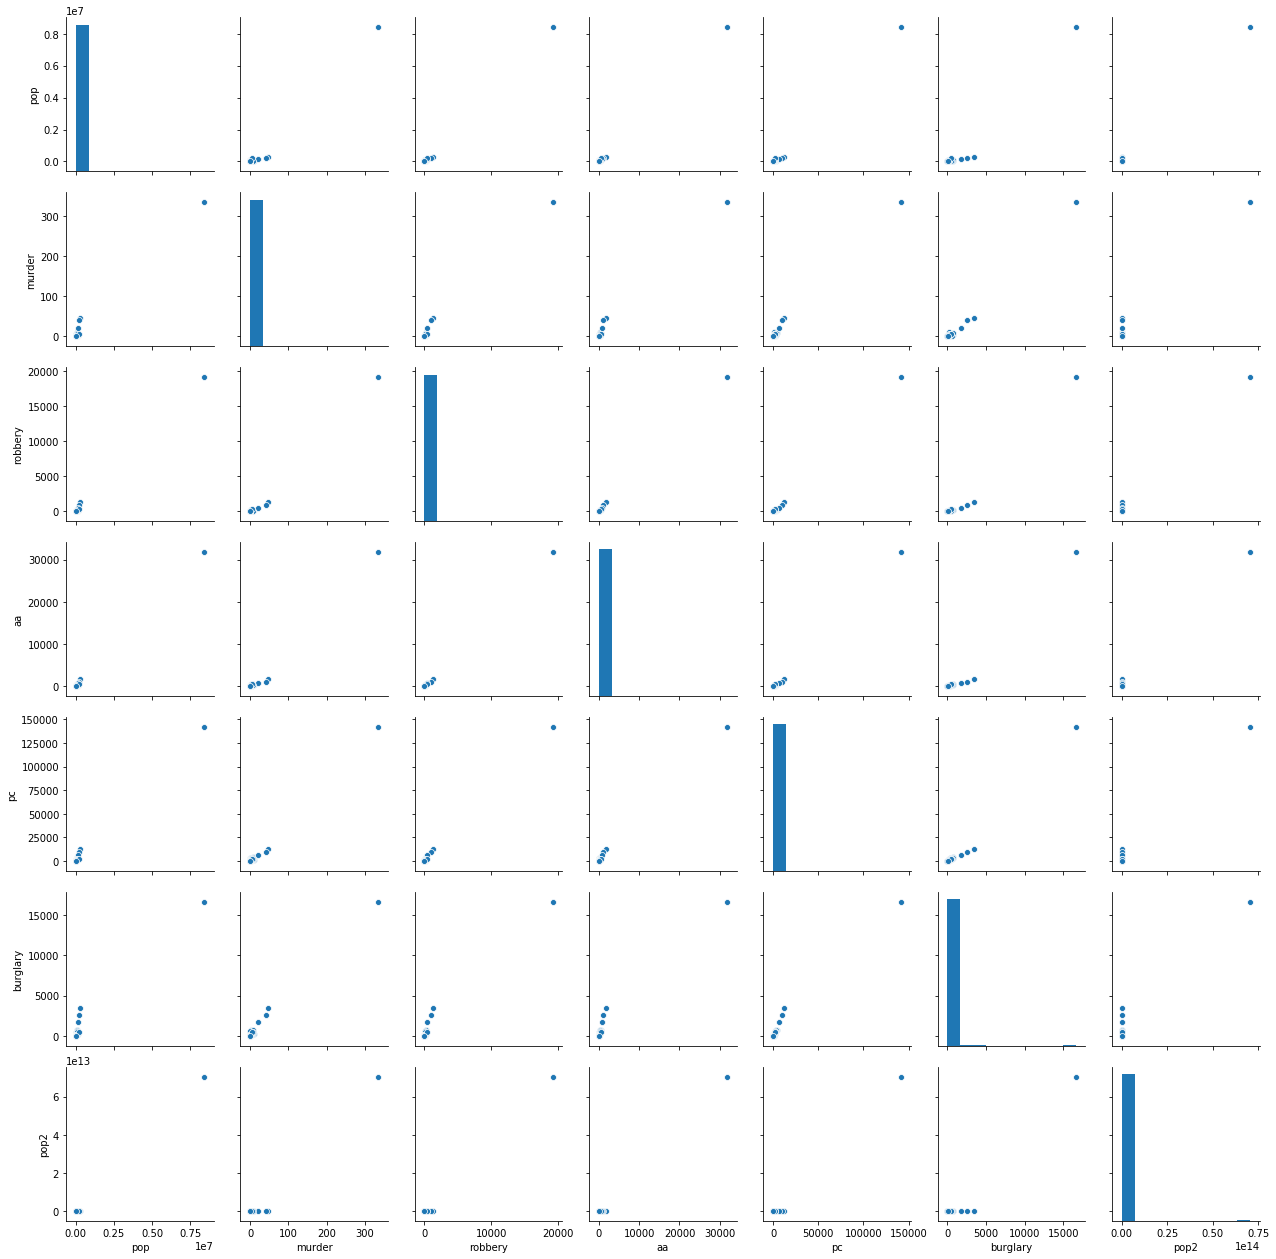

In [204]:
sns.pairplot(df_ny_some)

The above pairplot still includes NYC data which is not very helpful; it's too much of an outlier.  We have to drop NYC data.  Some features were dropped in order to read the pairplot better in accordance with the heatmap results.

In [205]:
# drop nyc data
df_ny_some_no_nyc = df_ny_some.drop([216])

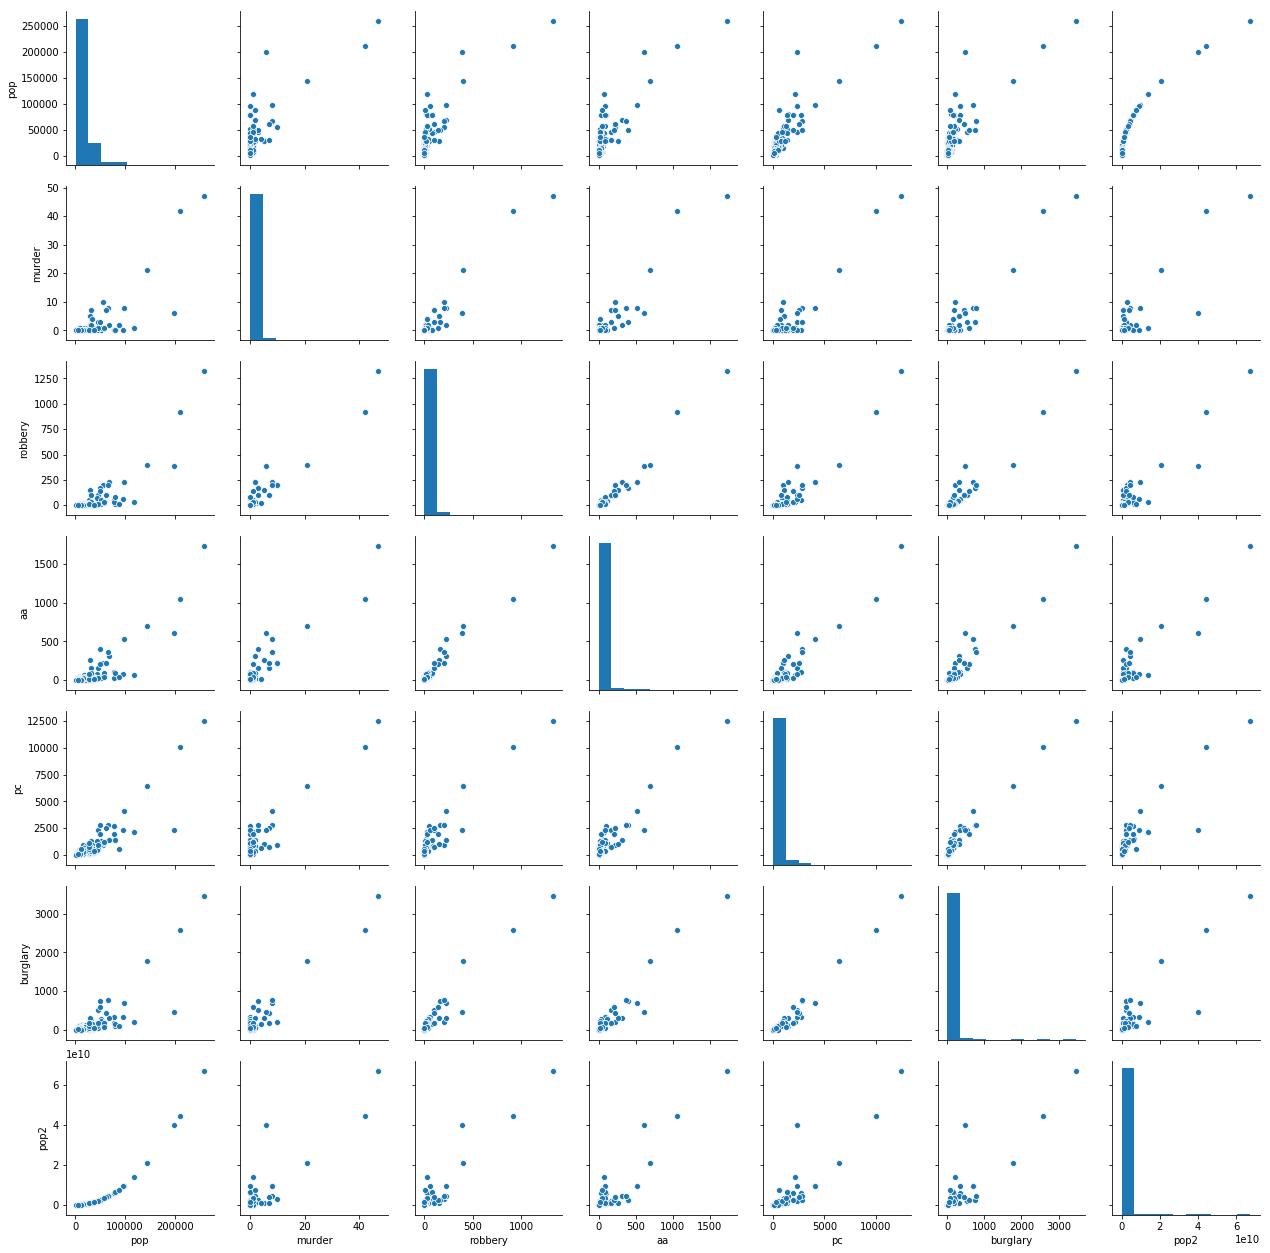

In [207]:
sns.pairplot(df_ny_some_no_nyc)

Here again, it looks like **burglary** is an excellent predictor (feature) for property crime.  You can see a very nice, very close to linear relationship with very few, if any outliers.

## Building the model

Without doing anything to the original data (data with NYC), build a multivariable regression equation using 'pop', 'murder' and 'robbery' for the features, or independent variables, to predict the property crime ('pc').

In [13]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.99344854357257


So the equation would be:  **y = -32.7 + .017(pop) + 607(murder) + 107(robbery)**  

The R-squared value is very close to 1 which might mean we have probably overfit the data.

Also, the population of the city in question needs to be at least **1924**, otherwise the model will predict a negative value for property crime occurrences which is impossible.

Now, let's build a model that excludes NYC.

In [14]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc']
X = df_no_nyc[['pop','murder','robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]

Intercept: 
 -108.42335403478899

R-squared:
0.7889428000907828


Now, the equation looks like:  **y = -108 + .034(pop) + 14.3(murder) - 94.3(robbery)**  

The new R-squared value is:  **0.79**  

This is probably more desirable and a better model and a good baseline equation to build on.  We must be aware that the population needs to be at least **3177**, otherwise the propery crime is negative which is impossible.

As a next step, let's just build a simple model that only uses the population feature to predict property crime with and without NYC data.  First we'll build it with NYC data included.

Coefficients: 
 [[0.01695663]]
Intercept: 
 [113.70298213]


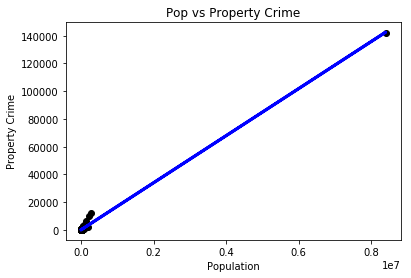

In [15]:
y = df_ny['pc'].values.reshape(-1, 1)
x = df_ny['pop'].values.reshape(-1, 1)

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# Plot outputs
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('Pop vs Property Crime')
plt.xlabel('Population')
plt.ylabel('Property Crime')
plt.show()

So the simple equation would be:  **y = 113.7 + .017(pop)**  

This may not be too bad.  As you can see there are no values of population (assuming it is at least 0) where the property crime would be predicted as a negative number.  Next, let's build the simple linear regression model excluding NYC data.

Coefficients: 
 [[0.03389004]]
Intercept: 
 [-155.02048926]


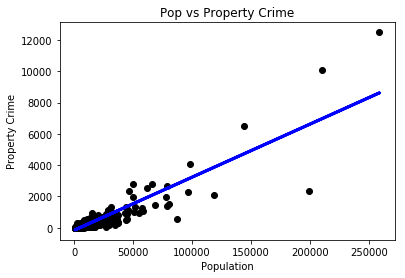

In [16]:
y = df_no_nyc['pc'].values.reshape(-1, 1)
x = df_no_nyc['pop'].values.reshape(-1, 1)

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(x, y)

# Display the attributes we calculated.
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# Plot outputs
plt.scatter(x, y, color='black')
plt.plot(x, regr.predict(x), color='blue', linewidth=3)
plt.title('Pop vs Property Crime')
plt.xlabel('Population')
plt.ylabel('Property Crime')
plt.show()

So the new equation, excluding NYC data, would be:  **y = -155 + .034(pop)**  

The population in this case has to be at least **4559** to yield a positive property crime prediction.

## Evaluating the model
The error from a multivariable model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed.  Let's check to make sure this is the case for our 2 models where we use 3 features to predict the outcome.  First we'll check the model with NYC data included.


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.99344854357257


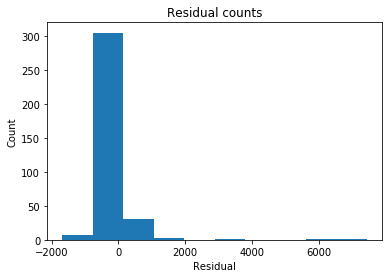

In [17]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df_ny['pc']

# Calculate the error, also called the residual.
residual = actual - predicted

# Creating histogram.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

Here we can see that residual data is fairly normally distributed; however it is slightly skewed to the right.  Next, let's look at the residual distribution after dropping NYC data.


Coefficients: 
 [[ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:
0.7889428000907828


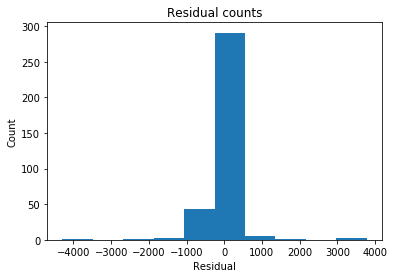

In [18]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc'].values.reshape(-1, 1)
X = df_no_nyc[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df_no_nyc['pc']

# Calculate the error, also called the residual.
residual = actual - predicted

# Creating histogram.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

This is much, much better.  It is more normally distributed and therefore much more helpful for prediction purposes.

As one last step, let's look at the scatterplots for the data with NYC and without NYC.


Coefficients: 
 [[1.68728222e-02 6.07383740e+02 1.06994709e+02]]

Intercept: 
 [-32.72226824]

R-squared:
0.99344854357257


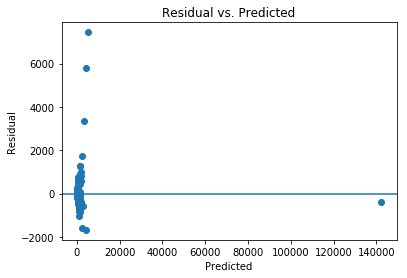

In [19]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_ny['pc'].values.reshape(-1, 1)
X = df_ny[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df_ny['pc']

# Calculate the error, also called the residual.
residual = actual - predicted

# creating a scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

As expected, we have a significant heteroskedasticity issue.  NYC data is the culprit.  Next, let's look at the plot without NYC data.


Coefficients: 
 [[ 3.43860764e-02  1.43473775e+01 -9.42521334e+01]]

Intercept: 
 [-108.42335403]

R-squared:
0.7889428000907828


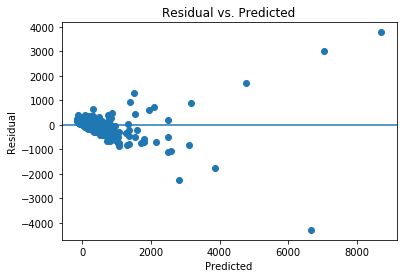

In [20]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df_no_nyc['pc'].values.reshape(-1, 1)
X = df_no_nyc[['pop', 'murder', 'robbery']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df_no_nyc['pc']

# Calculate the error, also called the residual.
residual = actual - predicted

# creating a scatterplot
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This is much more homoskedastic.  However, it is somewhoat cone shaped as the predicted values become larger, so it might be worth looking at ways to reduce this for further research.

## Discussion and conclusion

The main finding of this study to predict property crime with the inputs of population, murder and robbery is that the outlier - in this case NYC - significantly overfit the model and significantly reduces the effectiveness of this model if we were to use it to predict property crime in other states.  The obvious solution would be to remove NYC data, which we have done, in order to build a more robust and versatile model for future predictions.  

Sometimes a very simple model with just one input variable can be better than using multiple inputs.  We have shown that simply using population as a single input can yield a fiarly effective model, but here again, it In probably wise to omit NYC data because it overwhelms all of the other data.  

It is important to know the goals and future uses of the model and in this exercise we were not provided with those explanations.  For future model building and model validation, we need to consider the purpose of the model in order to test the results / predictions more effectively.